# Adevinta: Exploratory and Correlations Analysis

**Summay:** We have started with an exploratory analysis of the data provided. 

The dataset in question is about properties/real state defined by the following variables:
- **idproperty** – int propery identifier
- **province** – string (location data) : categorical nominal
- **municipality** – string (location data) : categorical nominal
- **surface** – int square meters : numerical
- **rooms** – int number of rooms : numerical or categorical ordinal (numerical in our choice)
- **baths** – int numeber of baths : numerical or categorical ordinal (numerical in our choice)
- **property_type** – string property type ("Vivienda" in our case so the variable has been dropped)
- **property_subtype** – string property subtype : categorical nominal ('Apartamento', 'Casa-Chalet', 'Piso', ...)
- **transaction_type** – string transaction type : categorical ("Sell", "Rent", "Share", "Added in Olap")
- **price** – float property price : numerical
- **description** – string description : textual data

The dataset contains 1208 observations and 11 variables, from which 3 idproperty, property_type and are not considered in this analysis for different reasons.

No missing values where found but only 904 unique idproperty's where found so, in we had to deal with the duplicates in the following way:

- **Separating the dataset** between Sell and Rent properties (Share is exclueded only 5 observations)
  * df_fotocasa_sell: Sell properties: 875 unique observations
  * df_fotocasa_rent: Rent properties: 181 unique observations
- **Not separating the dataset** but excluding price as a feature and only considering the descriptive features as rooms, surface... description for NLP and images for IMR

In most cases, we had to convert categorical variables into numerical ones. The reason why is that most of the machine learning algoriths, exept for decision trees, random forest and other cases work with numerical variables. The methodology followed has been:

- For location data (province and municipalitu): geolocation to latitude and longitude
- For the other cases we applied the .getdummies() function creating a variable for each category level (one-hot-encoding could have been another solution to this problem)


**Differences in distributions** 

There are significant differences in the distribution of surfaces, prices... between selling and renting properties.

**Correlations**

In Sell and Rent propeties there are strong correlations between surface, rooms and baths. Also in latitude and longitude

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
%matplotlib inline

In [85]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import mannwhitneyu, chisquare
import statsmodels.api as sm

## Adevinta: Dataset cleaning

### Adevinta: Dataset loading and description

In [4]:
df_fotocasa = pd.read_csv("./data/problem_data_reduced.csv",sep="|")

In [5]:
df_fotocasa.head()

,idproperty,province,municipality,surface,rooms,baths,property_type,property_subtype,transacion_type,price,description
0,qkgdhixsul,Girona,Castell-Platja d'Aro,60,2,1,Vivienda,Apartamento,Sell,178000.0,"apartamento de 60 m2, dsistribuido en cocina i..."
1,swigwvclxz,Barcelona,Vilanova i la Geltrú,197,4,2,Vivienda,Casa-Chalet,Sell,345000.0,VILANOVA I LA GELTRULes presentamos esta casa ...
2,bfvgsrcdoj,Lleida,Fondarella,375,5,3,Vivienda,Casa-Chalet,Sell,180000.0,
3,tsracvmevc,Girona,Girona Capital,89,4,2,Vivienda,Piso,Sell,187000.0,"Pis de 89m2, menjador de 23m2, cuina office de..."
4,biayppbmen,Barcelona,Manresa,180,6,1,Vivienda,Piso,Sell,350000.0,"MANRESA, piso de 6 habitaciones muy amplias to..."


In [6]:
print("\nObservations: {}, Features: {}\n".format(df_fotocasa.shape[0], df_fotocasa.shape[1]-1))


Observations: 1208, Features: 10



In [7]:
df_fotocasa.describe(include='all').fillna(-1)

,idproperty,province,municipality,surface,rooms,baths,property_type,property_subtype,transacion_type,price,description
count,1208,1208,1208,1208.000000,1208.000000,1208.000000,1208,1208,1208,1.208000e+03,1208
unique,904,4,365,-1.000000,-1.000000,-1.000000,1,10,4,-1.000000e+00,894
top,jyidsvhzha,Barcelona,Tarragona Capital,-1.000000,-1.000000,-1.000000,Vivienda,Casa-Chalet,Sell,-1.000000e+00,
freq,10,410,29,-1.000000,-1.000000,-1.000000,1208,367,923,-1.000000e+00,65
mean,-1,-1,-1,1272.086921,3.491722,2.047185,-1,-1,-1,2.386080e+05,-1
std,-1,-1,-1,29115.113512,1.600517,1.198698,-1,-1,-1,3.462939e+05,-1
min,-1,-1,-1,0.000000,0.000000,0.000000,-1,-1,-1,0.000000e+00,-1
25%,-1,-1,-1,80.000000,3.000000,1.000000,-1,-1,-1,4.909000e+04,-1
50%,-1,-1,-1,140.000000,3.000000,2.000000,-1,-1,-1,1.570000e+05,-1
75%,-1,-1,-1,240.000000,4.000000,3.000000,-1,-1,-1,2.888750e+05,-1


### Adevinta: Dataset missing values and duplicates

**missing values**

In [8]:
df_fotocasa.isna().sum()

idproperty          0
province            0
municipality        0
surface             0
rooms               0
baths               0
property_type       0
property_subtype    0
transacion_type     0
price               0
description         0
dtype: int64

**duplicates and zero observations in price**

Resolving duplicates we've selected the max price of the different observations.

In [9]:
df_fotocasa[["idproperty","transacion_type","price"]]\
    .groupby(["transacion_type"]).agg({
        'idproperty': pd.Series.nunique,
        'price': 'mean'
    })

,idproperty,price
transacion_type,,
Added in Olap,28,971.774194
Rent,176,4835.574297
Sell,880,310944.378115
Share,5,528.000000


In [11]:
cols = ['idproperty', 'province', 'municipality', 'surface', 'rooms', 'baths', 'property_subtype', 'price']

In [12]:
df_fotocasa_sell = df_fotocasa[cols][df_fotocasa.transacion_type == "Sell"].copy()
df_fotocasa_sell.head()

,idproperty,province,municipality,surface,rooms,baths,property_subtype,price
0,qkgdhixsul,Girona,Castell-Platja d'Aro,60,2,1,Apartamento,178000.0
1,swigwvclxz,Barcelona,Vilanova i la Geltrú,197,4,2,Casa-Chalet,345000.0
2,bfvgsrcdoj,Lleida,Fondarella,375,5,3,Casa-Chalet,180000.0
3,tsracvmevc,Girona,Girona Capital,89,4,2,Piso,187000.0
4,biayppbmen,Barcelona,Manresa,180,6,1,Piso,350000.0


In [13]:
df_fotocasa_sell.shape

(923, 8)

In [16]:
df_fotocasa_sellmax = df_fotocasa_sell.groupby(cols[:-1]).max().reset_index()
df_fotocasa_sellmax.shape

(880, 8)

In [17]:
df_fotocasa[cols+["transacion_type"]][df_fotocasa.idproperty.isin(
    df_fotocasa_sellmax[df_fotocasa_sellmax.price <= 0.0].idproperty)]

,idproperty,province,municipality,surface,rooms,baths,property_subtype,price,transacion_type
327,dggkimsrvs,Barcelona,Cànoves I Samalús,420,5,4,Finca rústica,0.000000,Sell
718,dvtvzmbbbj,Tarragona,Tortosa,1350,10,7,Piso,0.000000,Sell
805,gditzgymnh,Barcelona,Vic,76,3,2,Piso,0.000000,Sell
813,gwvzyjlihr,Tarragona,Salou,60,2,1,Apartamento,0.000000,Sell
814,gwvzyjlihr,Tarragona,Salou,60,2,1,Apartamento,0.000000,Rent
815,gwvzyjlihr,Tarragona,Salou,60,2,1,Apartamento,85.714286,Rent
1097,tahcvjcapb,Lleida,Sant Esteve de la Sarga,0,2,1,Finca rústica,0.000000,Sell


In [18]:
df_fotocasa_sellmax = df_fotocasa_sellmax[df_fotocasa_sellmax.price > 0.0].copy()
df_fotocasa_sellmax.shape

(875, 8)

In [14]:
df_fotocasa_rent = df_fotocasa[cols][df_fotocasa.transacion_type == "Rent"].copy()
df_fotocasa_rent.head()

,idproperty,province,municipality,surface,rooms,baths,property_subtype,price
18,qfbfgxlvny,Girona,Palafrugell,64,2,1,Piso,0.0
23,wxmowdcmmi,Tarragona,Cunit,250,5,2,Casa-Chalet,1200.0
24,wxmowdcmmi,Tarragona,Cunit,250,5,2,Casa-Chalet,1400.0
27,nhubamixyx,Tarragona,Tarragona Capital,65,3,1,Piso,480.0
44,egrxdkzzxs,Girona,Anglès,193,4,3,Casa adosada,600.0


In [15]:
df_fotocasa_rent.shape

(249, 8)

In [19]:
df_fotocasa_rentmax = df_fotocasa_rent.groupby(cols[:-1]).max().reset_index()
df_fotocasa_rentmax.shape

(176, 8)

In [20]:
df_fotocasa[cols+["transacion_type"]][df_fotocasa.idproperty.isin(
    df_fotocasa_rentmax[df_fotocasa_rentmax.price <= 0.0].idproperty)]

,idproperty,province,municipality,surface,rooms,baths,property_subtype,price,transacion_type
17,qfbfgxlvny,Girona,Palafrugell,64,2,1,Piso,140000.0,Sell
18,qfbfgxlvny,Girona,Palafrugell,64,2,1,Piso,0.0,Rent
19,qfbfgxlvny,Girona,Palafrugell,64,2,1,Piso,500.0,Added in Olap
163,ficxqwjpln,Barcelona,Castellnou de Bages,372,6,2,Casa-Chalet,825000.0,Sell
164,ficxqwjpln,Barcelona,Castellnou de Bages,372,6,2,Casa-Chalet,0.0,Rent
262,pmsihtciwj,Lleida,Camarasa,51,3,1,Finca rústica,80000.0,Sell
263,pmsihtciwj,Lleida,Camarasa,51,3,1,Finca rústica,0.0,Rent
421,wclkpmeyoh,Tarragona,Sant Carles de la Ràpita,68,2,1,Apartamento,69000.0,Sell
422,wclkpmeyoh,Tarragona,Sant Carles de la Ràpita,68,2,1,Apartamento,0.0,Rent
527,fxkfyhixdw,Tarragona,Amposta,116,2,1,Apartamento,79000.0,Sell


In [21]:
df_fotocasa_rentmax = df_fotocasa_rentmax[df_fotocasa_rentmax.price > 0.0].copy()
df_fotocasa_rentmax.shape

(161, 8)

In [23]:
df_fotocasa.to_pickle("./data/df_fotocasa.pkl")

In [37]:
df_fotocasa_sellmax.to_pickle("./data/df_fotocasa_sell.pkl")

In [39]:
df_fotocasa_sel = pd.read_pickle("./data/df_fotocasa_sell.pkl")

In [38]:
df_fotocasa_rentmax.to_pickle("./data/df_fotocasa_rent.pkl")

In [40]:
df_fotocasa_rent = pd.read_pickle("./data/df_fotocasa_rent.pkl")

## Adevinta: Features exploratory analysis

### Adevinta: Features: Numerical

The Mann-Whitney U test is a nonparametric statistical significance test for determining whether two independent samples were drawn from a population with the same distribution.

In [56]:
def mann_wihitney(data1, data2):
    # Mann-Whitney U test (non-parametric test)
    # compare samples
    stat, p = mannwhitneyu(data1, data2)
    print('Statistics=%.3f, p=%.3f' % (stat, p))
    # interpret
    alpha = 0.05
    if p > alpha:
        print('Same distribution (fail to reject H0)')
    else:
        print('Different distribution (reject H0)')

**surface**

In [26]:
df_fotocasa.surface.describe()

count      1208.000000
mean       1272.086921
std       29115.113512
min           0.000000
25%          80.000000
50%         140.000000
75%         240.000000
max      980000.000000
Name: surface, dtype: float64

In [27]:
df_fotocasa[df_fotocasa.idproperty.isin(df_fotocasa[df_fotocasa.surface == 0.0].idproperty)]

,idproperty,province,municipality,surface,rooms,baths,property_type,property_subtype,transacion_type,price,description
237,spjeblyxra,Lleida,Les Borges Blanques,0,0,0,Vivienda,Casa-Chalet,Sell,51500.000000,"Casa a reformar a la carretera de Lleida, molt..."
238,amoyanwken,Girona,Salt,0,3,2,Vivienda,Casa-Chalet,Sell,180000.000000,Es una casa composta de planta baixa a local d...
419,lbmmufshqo,Barcelona,Cerdanyola del Vallès,0,6,5,Vivienda,Casa-Chalet,Sell,890000.000000,Casa en venta en la parte alta de Bellaterra (...
425,eihufyxpes,Lleida,Lleida Capital,0,4,4,Vivienda,Dúplex,Sell,460000.000000,Amplio y luminoso Dúplex en planta baja de 175...
531,ubnvkkysgw,Tarragona,Vandellòs i l'Hospitalet de l'Infant,0,2,1,Vivienda,Apartamento,Rent,57.142857,Apartamento de 2 dormitorios dobles con ventil...
710,bewuyvcwzx,Lleida,Gavet de la Conca,0,4,1,Vivienda,Casa-Chalet,Sell,70000.000000,Casa de pedra reformada estructuralment la faç...
737,jiyywpylxg,Girona,Camprodon,0,1,1,Vivienda,Piso,Sell,125000.000000,"Apartamento de una habitación, cocina-comedor,..."
836,kfewuixhwm,Girona,Camprodon,0,2,1,Vivienda,Apartamento,Sell,119000.000000,Venta o alquiler de temporada al centro de Cam...
837,kfewuixhwm,Girona,Camprodon,0,2,1,Vivienda,Apartamento,Rent,400.000000,Venta o alquiler de temporada al centro de Cam...
838,kfewuixhwm,Girona,Camprodon,0,2,1,Vivienda,Apartamento,Rent,12.666667,Venta o alquiler de temporada al centro de Cam...


Text(0.5, 0.98, 'Surface measure distribution with and without outliers')

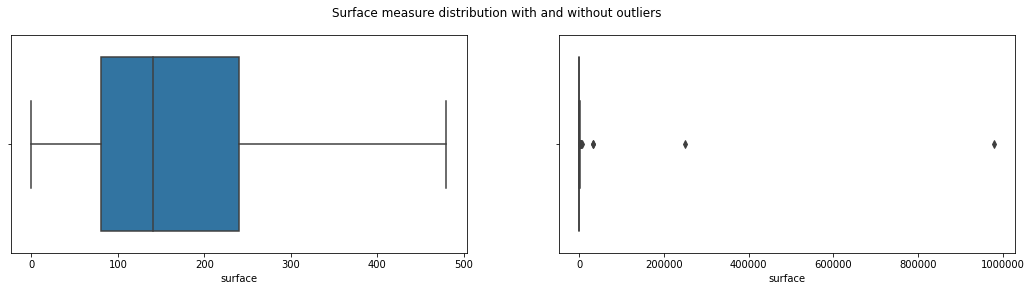

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,4))
ax1 = sns.boxplot(x=df_fotocasa.surface, showfliers=False, ax=ax1)
ax2 = sns.boxplot(x=df_fotocasa.surface, ax=ax2)
fig.suptitle("Surface measure distribution with and without outliers")

Text(0.5, 0.98, 'Surface measure SELL distribution with and without outliers')

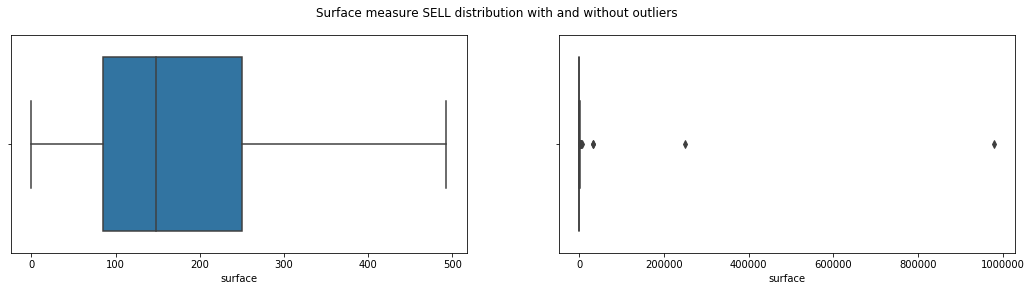

In [41]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,4))
ax1 = sns.boxplot(x=df_fotocasa_sell.surface, showfliers=False, ax=ax1)
ax2 = sns.boxplot(x=df_fotocasa_sell.surface, ax=ax2)
fig.suptitle("Surface measure SELL distribution with and without outliers")

Text(0.5, 0.98, 'Surface measure RENT distribution with and without outliers')

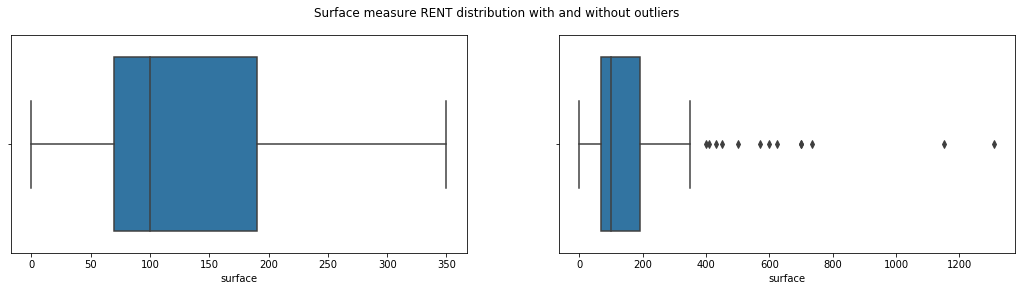

In [42]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,4))
ax1 = sns.boxplot(x=df_fotocasa_rent.surface, showfliers=False, ax=ax1)
ax2 = sns.boxplot(x=df_fotocasa_rent.surface, ax=ax2)
fig.suptitle("Surface measure RENT distribution with and without outliers")

In [59]:
mann_wihitney(df_fotocasa_sell.surface, df_fotocasa_rent.surface)

Statistics=58269.500, p=0.000
Different distribution (reject H0)


**Conclusion:** There are significant differences in the distribution of surfaces between selling and renting properties.

**price**

In [43]:
df_fotocasa.price.describe()

count    1.208000e+03
mean     2.386080e+05
std      3.462939e+05
min      0.000000e+00
25%      4.909000e+04
50%      1.570000e+05
75%      2.888750e+05
max      3.900000e+06
Name: price, dtype: float64

Text(0.5, 0.98, 'Price measure distribution with and without outliers')

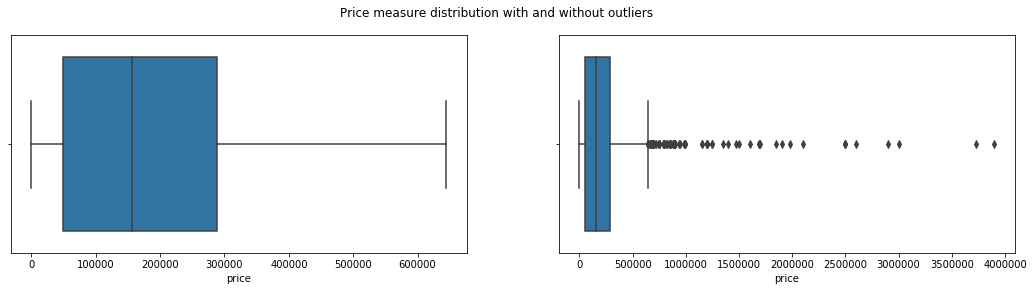

In [77]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,4))
ax1 = sns.boxplot(x=df_fotocasa.price, showfliers=False, ax=ax1)
ax2 = sns.boxplot(x=df_fotocasa.price, ax=ax2)
fig.suptitle("Price measure distribution with and without outliers")

Text(0.5, 0.98, 'Price measure SELL distribution with and without outliers')

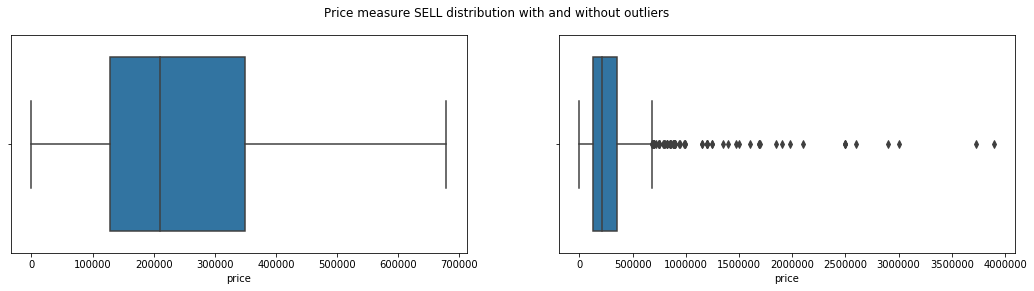

In [78]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,4))
ax1 = sns.boxplot(x=df_fotocasa_sell.price, showfliers=False, ax=ax1)
ax2 = sns.boxplot(x=df_fotocasa_sell.price, ax=ax2)
fig.suptitle("Price measure SELL distribution with and without outliers")

Text(0.5, 0.98, 'Price measure RENT distribution with and without outliers')

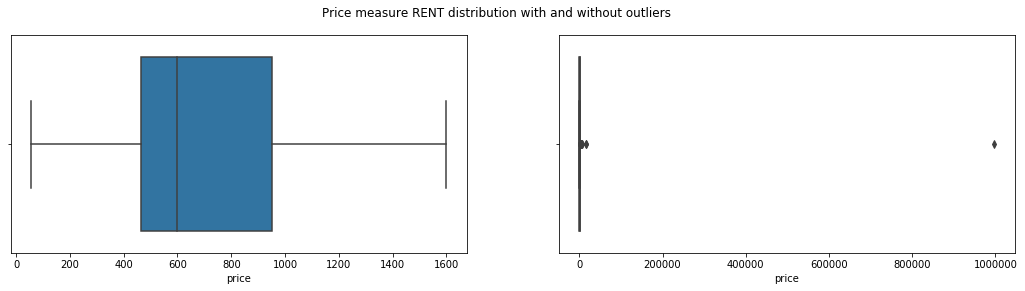

In [79]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,4))
ax1 = sns.boxplot(x=df_fotocasa_rent.price, showfliers=False, ax=ax1)
ax2 = sns.boxplot(x=df_fotocasa_rent.price, ax=ax2)
fig.suptitle("Price measure RENT distribution with and without outliers")

In [64]:
mann_wihitney(df_fotocasa_sell.price, df_fotocasa_rent.price)

Statistics=1798.500, p=0.000
Different distribution (reject H0)


**Conclusion:** There are significant differences in the distribution of prices between selling and renting properties.

### Adevinta: Features: Categorical (ordinal)

**rooms**

In [67]:
sorted(df_fotocasa.rooms.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 20]

Text(0.5, 0.98, 'Rooms distribution in original, sell and rent datasets')

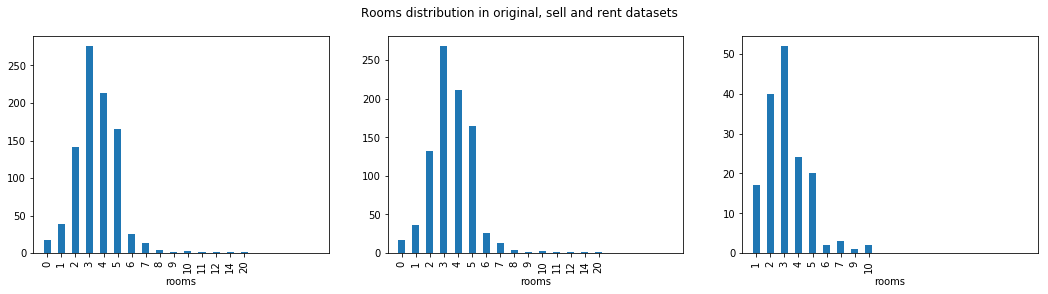

In [84]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))

ax1 = df_fotocasa[["rooms","idproperty"]].groupby("rooms").nunique().idproperty.plot(kind='bar', ax=ax1)
ax1.set_xlim(-1,20)
ax2 = df_fotocasa_sell[["rooms","idproperty"]].groupby("rooms").nunique().idproperty.plot(kind='bar', ax=ax2)
ax2.set_xlim(-1,20)
ax3 = df_fotocasa_rent[["rooms","idproperty"]].groupby("rooms").nunique().idproperty.plot(kind='bar', ax=ax3)
ax3.set_xlim(-1,20)
fig.suptitle("Rooms distribution in original, sell and rent datasets")

**baths**

In [82]:
sorted(df_fotocasa.baths.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]

Text(0.5, 0.98, 'Baths distribution on original, sell and rent datasets')

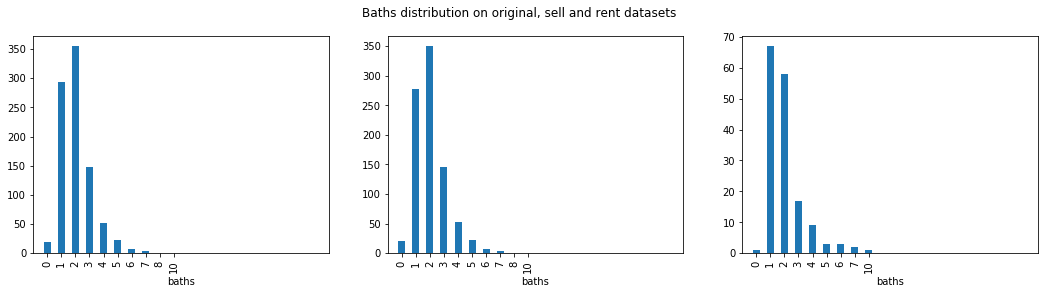

In [83]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(18,4))

ax1 = df_fotocasa[["baths","idproperty"]].groupby("baths").nunique().idproperty.plot(kind='bar', ax=ax1)
ax1.set_xlim(-1,20)
ax2 = df_fotocasa_sell[["baths","idproperty"]].groupby("baths").nunique().idproperty.plot(kind='bar', ax=ax2)
ax2.set_xlim(-1,20)
ax3 = df_fotocasa_rent[["baths","idproperty"]].groupby("baths").nunique().idproperty.plot(kind='bar', ax=ax3)
ax3.set_xlim(-1,20)
fig.suptitle("Baths distribution in original, sell and rent datasets")

### Adevinta: Features: Categorical (nominal)

**transacion type**

In [121]:
df_fotocasa.transacion_type.unique()

array(['Sell', 'Rent', 'Added in Olap', 'Share'], dtype=object)

In [122]:
df_fotocasa.groupby("transacion_type").nunique()[["idproperty"]].sort_values(by='idproperty',ascending=False)

,idproperty
transacion_type,
Sell,880
Rent,176
Added in Olap,28
Share,5


**property type and subtype**

In [88]:
df_fotocasa.property_type.unique()

array(['Vivienda'], dtype=object)

In [89]:
df_fotocasa.property_subtype.unique()

array(['Apartamento', 'Casa-Chalet', 'Piso', 'Casa adosada',
       'Finca rústica', 'Ático', 'Dúplex', 'Estudio', 'Planta baja',
       'Loft'], dtype=object)

Text(0.5, 0.98, 'Baths distribution Sell and Rent datasets')

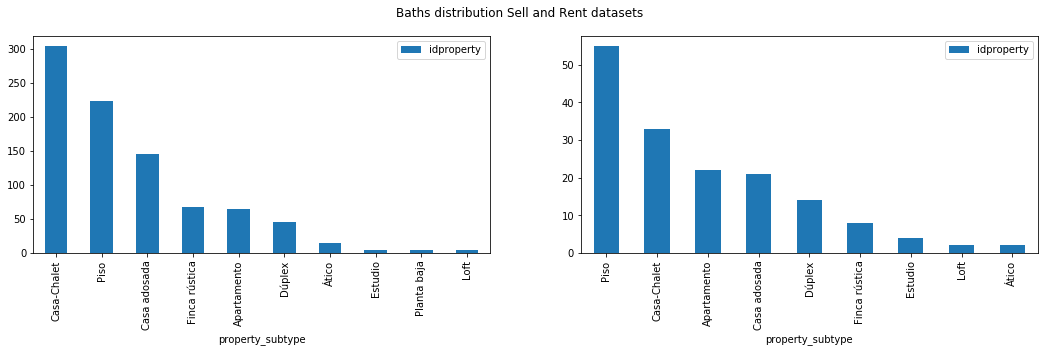

In [96]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,4))

ax1 = df_fotocasa_sell[["property_subtype","idproperty"]].groupby("property_subtype").nunique() \
        [["idproperty"]].sort_values(by='idproperty',ascending=False).plot(kind='bar', ax=ax1)
ax2 = df_fotocasa_rent[["property_subtype","idproperty"]].groupby("property_subtype").nunique() \
        [["idproperty"]].sort_values(by='idproperty',ascending=False).plot(kind='bar', ax=ax2)
fig.suptitle("Baths distribution Sell and Rent datasets")

**province & municipality**

In [100]:
df_fotocasa.province.unique()

array(['Girona', 'Barcelona', 'Lleida', 'Tarragona'], dtype=object)

In [101]:
df_fotocasa.groupby("province").nunique()[["idproperty"]].sort_values(by='idproperty',ascending=False)

,idproperty
province,
Barcelona,317
Tarragona,280
Girona,180
Lleida,127


In [ ]:
df_fotocasa.municipality.unique()

In [102]:
len(df_fotocasa.municipality.unique())

365

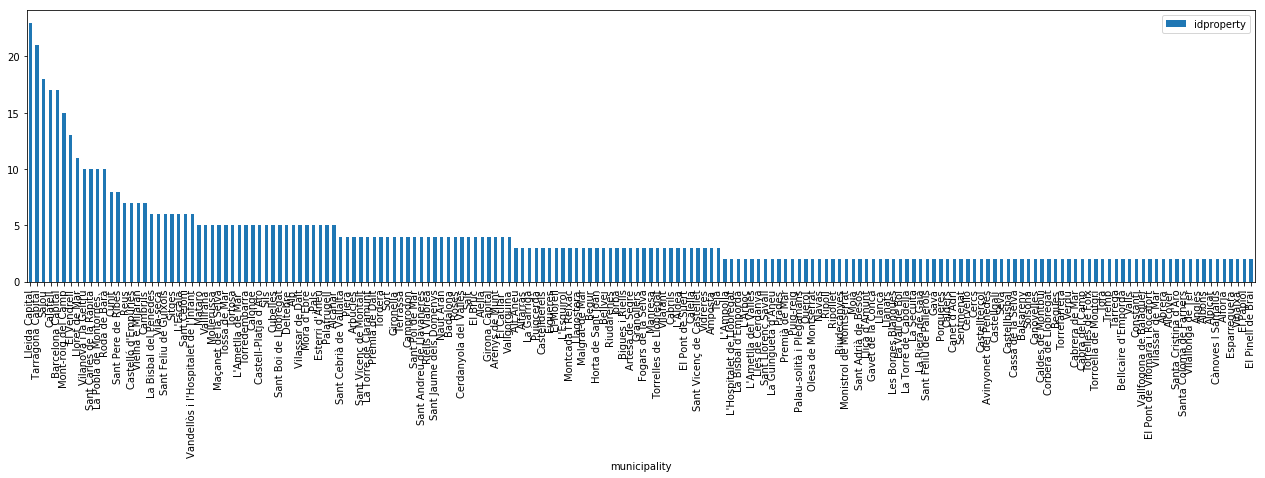

In [110]:
df = df_fotocasa.groupby("municipality").nunique() \
    [["idproperty"]].sort_values(by='idproperty',ascending=False)

df[df.idproperty > 1.0].plot(kind='bar', figsize=(22,5))

In [114]:
df.reset_index().groupby('idproperty').nunique()[['municipality']]

,municipality
idproperty,
1,183
2,79
3,31
4,26
5,21
6,7
7,4
8,2
10,4


Geocoding province and municipality into latitude and longitude

In [97]:
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

def get_geocoded_locations(df_data):
    # create the address based on province and municipality
    df_geo = df_data.copy()
    df_geo["address"] = df_geo.province + ", " + df_geo.municipality
    df_geo = df_data[
        ["idproperty","address"]
    ].groupby("idproperty").first().reset_index()

    # change capitals address to be geocoded
    capitals = {
        'Barcelona, Barcelona Capital': 'Barcelona, Barcelona, Spain',
        'Lleida,  Lleida Capital': 'Lleida, Lleida, Spain', 
        'Tarragona,  Tarragona Capital': 'Tarragona, Tarragona, Spain',
        'Girona, Girona Capital': 'Girona, Girona, Spain',
    }
    df_geo.address = df_geo.address.apply(
        lambda x : capitals[x] if x in capitals.keys() else x)

    # geocoding with geoapi
    geolocator = Nominatim()
    geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

    df_geo['location'] = df_geo['address'].apply(geocode)
    df_geo['point'] = df_geo['location'].apply(
        lambda loc: tuple(loc.point) if loc else None)
    
    # extract latitude and longitude from location points
    df_geo['latitude'] = df_geo.point.apply(lambda x : x[0])
    df_geo['longitude'] = df_geo.point.apply(lambda x : x[1])
    return geo

In [99]:
df_geo = get_geocoded_locations(df_fotocasa)
df_geo.shape

(904, 6)

In [115]:
df_geo.head()

,idproperty,address,location,point,latitude,longitude
0,abkvpehvdk,"Barcelona, Sant Pere de Ribes","(Sant Pere de Ribes, Garraf, BCN, CAT, España,...","(41.2619218, 1.7721357, 0.0)",41.261922,1.772136
1,abrrpeggwd,"Barcelona, Tordera","(Tordera, Maresme, BCN, CAT, 08490, España, (4...","(41.6977173, 2.7172987, 0.0)",41.697717,2.717299
2,adqphxnrhg,"Girona, Torroella de Montgrí","(Torroella de Montgrí, Baix Empordà, Girona, C...","(42.040982, 3.1262041, 0.0)",42.040982,3.126204
3,adsvpzczjm,"Tarragona, Solivella","(Solivella, Conca de Barberà, Tarragona, CAT, ...","(41.4551755, 1.1782848, 0.0)",41.455176,1.178285
4,aemkznotwk,"Girona, Ripoll","(Ripoll, Ripollès, Girona, CAT, 17500, España,...","(42.1982391, 2.1932496, 0.0)",42.198239,2.193250


In [118]:
df_fotocasa_ = pd.merge(
    df_fotocasa,
    df_geo[['idproperty','latitude','longitude']],
    how='left',
    on='idproperty'
)

In [120]:
df_fotocasa_sell_ = pd.merge(
    df_fotocasa_sell,
    df_geo[['idproperty','latitude','longitude']],
    how='left',
    on='idproperty'
)

In [119]:
df_fotocasa_rent_ = pd.merge(
    df_fotocasa_rent,
    df_geo[['idproperty','latitude','longitude']],
    how='left',
    on='idproperty'
)

In [123]:
df_fotocasa_.to_pickle("./data/df_fotocasa.pkl")

In [124]:
df_fotocasa_sell_.to_pickle("./data/df_fotocasa_sell.pkl")

In [125]:
df_fotocasa_rent_.to_pickle("./data/df_fotocasa_rent.pkl")

## Adevinta: Feature correlations

In [153]:
def get_numerical_dataframe(df_fotocasa_):
    df_fotocasa_vars = \
        df_fotocasa_[['surface','rooms','baths',
                      'latitude','longitude','price',
                      'property_subtype']] \
            .groupby(['surface','rooms','baths','latitude',
                      'property_subtype','longitude']) \
            .max().reset_index()

    df_fotocasa_property_subtype = pd.get_dummies(df_fotocasa_vars.property_subtype)

    df_fotocasa_new = pd.concat([
        df_fotocasa_vars[['surface','rooms','baths',
            'latitude','longitude','price']], 
        df_fotocasa_property_subtype,
    ], axis=1,sort=False)
    return df_fotocasa_new

In [154]:
df_fotocasa_new = get_numerical_dataframe(df_fotocasa_)

In [155]:
df_fotocasa_sell_new = get_numerical_dataframe(df_fotocasa_sell_)

In [156]:
df_fotocasa_rent_new = get_numerical_dataframe(df_fotocasa_rent_)

In [139]:
df_fotocasa_new.corr()

,surface,rooms,baths,latitude,longitude,price,Apartamento,Casa adosada,Casa-Chalet,Dúplex,Estudio,Finca rústica,Loft,Piso,Planta baja,Ático
surface,1.000000,-0.084183,-0.069339,0.012255,0.005485,-0.015491,-0.013855,-0.018953,-0.029742,-0.010635,-0.003615,0.151821,-0.003141,-0.026525,-0.003416,-0.006036
rooms,-0.084183,1.000000,0.671194,0.040613,0.053278,0.492763,-0.277708,0.060833,0.305226,-0.074182,-0.127971,0.167168,-0.074997,-0.219516,-0.035181,-0.055894
baths,-0.069339,0.671194,1.000000,-0.005098,0.006357,0.588215,-0.189198,0.086622,0.297912,0.005899,-0.067426,0.050644,-0.046020,-0.269420,-0.016403,-0.080417
latitude,0.012255,0.040613,-0.005098,1.000000,0.994629,-0.145979,-0.018814,0.056354,0.050628,-0.082383,0.014603,0.047068,-0.123885,-0.067604,0.012100,0.012550
longitude,0.005485,0.053278,0.006357,0.994629,1.000000,-0.126789,-0.026124,0.054063,0.066085,-0.093609,0.014866,0.041242,-0.122023,-0.069585,0.015035,0.012760
price,-0.015491,0.492763,0.588215,-0.145979,-0.126789,1.000000,-0.125323,-0.055606,0.280708,-0.061107,-0.050955,0.137553,-0.031121,-0.203549,-0.018685,-0.045548
Apartamento,-0.013855,-0.277708,-0.189198,-0.018814,-0.026124,-0.125323,1.000000,-0.131089,-0.214127,-0.069096,-0.022248,-0.085124,-0.019888,-0.172103,-0.022248,-0.038753
Casa adosada,-0.018953,0.060833,0.086622,0.056354,0.054063,-0.055606,-0.131089,1.000000,-0.319683,-0.103157,-0.033215,-0.127086,-0.029691,-0.256942,-0.033215,-0.057857
Casa-Chalet,-0.029742,0.305226,0.297912,0.050628,0.066085,0.280708,-0.214127,-0.319683,1.000000,-0.168502,-0.054254,-0.207588,-0.048499,-0.419701,-0.054254,-0.094506
Dúplex,-0.010635,-0.074182,0.005899,-0.082383,-0.093609,-0.061107,-0.069096,-0.103157,-0.168502,1.000000,-0.017507,-0.066986,-0.015650,-0.135432,-0.017507,-0.030496


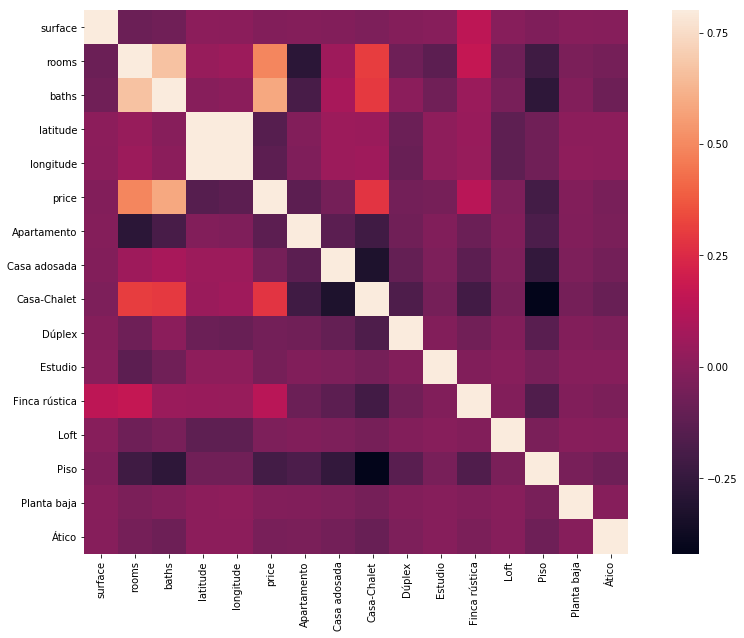

In [138]:
plt.figure(figsize=(16,10))
sns.heatmap(df_fotocasa_new.corr(), vmax = .8, square = True)
plt.show()

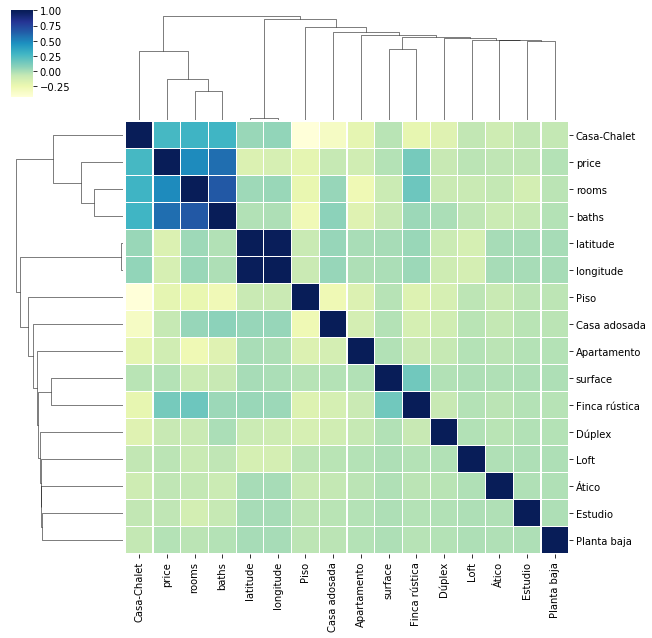

In [157]:
cg = sns.clustermap(df_fotocasa_sell_new.corr(), cmap ="YlGnBu", linewidths = 0.1)

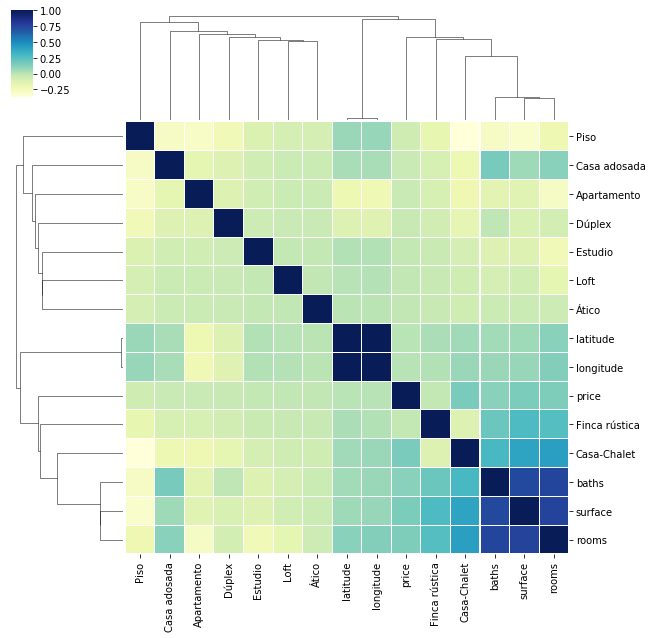

In [158]:
cg = sns.clustermap(df_fotocasa_rent_new.corr(), cmap ="YlGnBu", linewidths = 0.1)

**Catgeorical associations**

Calculate **Cramers V statistic for categorial-categorial association**. It is based on a nominal variation of Pearson’s Chi-Square Test, and comes built-in with some great benefits:
Similarly to correlation, the output is in the range of 0..1, where 0 means no association and 1 is full association. 

In [146]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [152]:
cat_list = ['province','municipality','property_subtype','transacion_type']

for var_x in cat_list:
    x = df_fotocasa[var_x]
    for var_y in cat_list:
        y = df_fotocasa[var_y]
        cor = cramers_v(x, y)
        print("{} and {} correlation: {}"\
          .format(var_x,var_y,round(cor,5))
        )

province and province correlation: 1.0
province and municipality correlation: 0.83676
province and property_subtype correlation: 0.17777
province and transacion_type correlation: 0.03964
municipality and province correlation: 0.83676
municipality and municipality correlation: 1.0
municipality and property_subtype correlation: 0.36951
municipality and transacion_type correlation: 0.0
property_subtype and province correlation: 0.17777
property_subtype and municipality correlation: 0.36951
property_subtype and property_subtype correlation: 1.0
property_subtype and transacion_type correlation: 0.0886
transacion_type and province correlation: 0.03964
transacion_type and municipality correlation: 0.0
transacion_type and property_subtype correlation: 0.0886
transacion_type and transacion_type correlation: 1.0
